# Climate Change Tweet Classification

# Introduction

Kaggle is hosting a Climate Change Belief Analysis competition which aims to predict an individual's belief in climate change based on historical tweet data.

The results from the prediction will help companies better understand their customer's perception on climate change. Such an analysis or prediction will help companies determine how their products will be recieved; thus guiding their marketing strategy and their production processes. 
Providing a solution to this task will provide access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies. The model will be deployed to the **streamlit** application which can be used remotely through the use of an AWS EC2 instance.

## Problem statement 

Companies are looking to create products that are environmentally friendly. Thus they would like to understand their consumers' view on climate change. To address this, we are going to create Machine Learning models that are able to classify whether or not a person believes in climate change, based on their novel tweet data. Correct classification of a tweet will help companies understand consumer sentiment, which will further guide their business strategies.

## Table of Contents

1. Introduction
2. Importing Libraries
3. Importing Dataset
4. Data Preprocessing
5. Exploratory Data Analysis
6. Feature Engineering and Selection
7. Model Selection 
8. Model Evaluation
9. References

## Comet

Comet is a great tool for model versioning and experimentation as it records the parameters and conditions from each of the experiements- allowing for reproducing of results, or going back to a previous version of the experiment.

In [1]:
!pip install comet_ml

### Import Libraries

In [2]:
# Importing modules for data science and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 180 # Quality of all figures in notebook
# NLP Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import pos_tag
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install nlppreprocess

In [4]:
from nlppreprocess import NLP

## Importing dataset

In [5]:
# Loading in the datasets
traindata = pd.read_csv("train.csv")
testdata = pd.read_csv("test_with_no_labels.csv")

## Data Preprocessing

### Summary statistics 

In [6]:
# Looking at the first few entries in the dataset
traindata.head()

,sentiment,message,tweetid
0,-1,RT @darreljorstad: Funny as hell! Canada deman...,897853122080407553
1,-1,All the biggest lies about climate change and ...,925046776553529344
2,-1,The Coming Revelation Of The $q$Global Warming...,696354236850786305
3,-1,RT @DineshDSouza: Let's see if the world ends ...,846806509732483072
4,-1,RT @SteveSGoddard: Obama has no control over t...,628085266293653504


In [7]:
testdata.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [8]:
# Shape of the dataset
traindata.shape

(30759, 3)

In [9]:
# dataframe information
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30759 entries, 0 to 30758
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  30759 non-null  int64 
 1   message    30759 non-null  object
 2   tweetid    30759 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 721.0+ KB


In [10]:
# Looking at the numbers of possible classes in our sentiment
traindata['sentiment'].unique()

array([-1,  0,  1,  2], dtype=int64)

In [11]:
# Looking at the how the messages are distributed across the sentiment
traindata.describe()

,sentiment,tweetid
count,30759.000000,3.075900e+04
mean,0.853929,8.364330e+17
std,0.853551,8.519986e+16
min,-1.000000,5.926334e+17
25%,0.000000,7.970301e+17
50%,1.000000,8.401516e+17
75%,1.000000,8.996975e+17
max,2.000000,9.666876e+17


## Missing values

In [12]:
# Checking for missing values
traindata.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

In [13]:
# Checking whether a character is white-space character or not
print(len(traindata['message']))
print(sum(traindata['message'].apply(lambda x: x.isspace())))

30759
0


In [14]:
# Sample tweet
tweet = traindata.iloc[6,1]
print(tweet)

RT @T_S_P_O_O_K_Y: @beardoweird0 @20committee I actually have a degree in Environmental Studies - and yes - man made climate change is a ho…


Text(0.5, 1.0, 'Distribution of target labels')

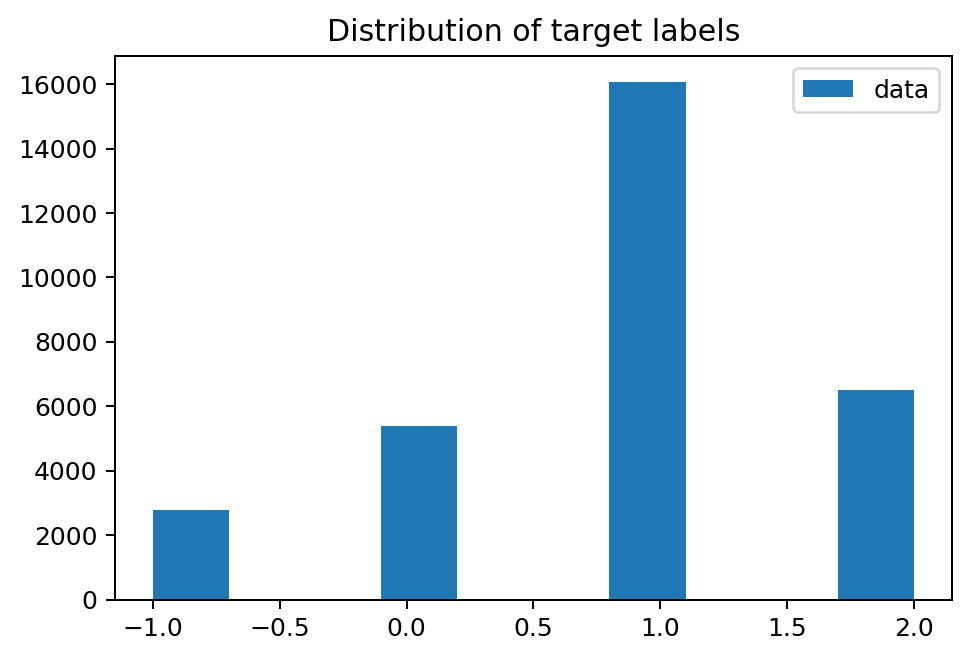

In [15]:
# Visualizing the distribution of the target 
plt.hist(traindata['sentiment'], label='data');
plt.legend();
plt.title('Distribution of target labels')

It is notable that there is an imbalance of classes in the daset and these tend to be a common problem in machine learning classification where there are a disproportionate ratio of observations in each class. This is can cause problems as most algorithms are designed to maximize accuracy and reduce error. Therefore we ill address and take care of the class imbalance in our EDA.

Text(0, 0.5, 'Density')

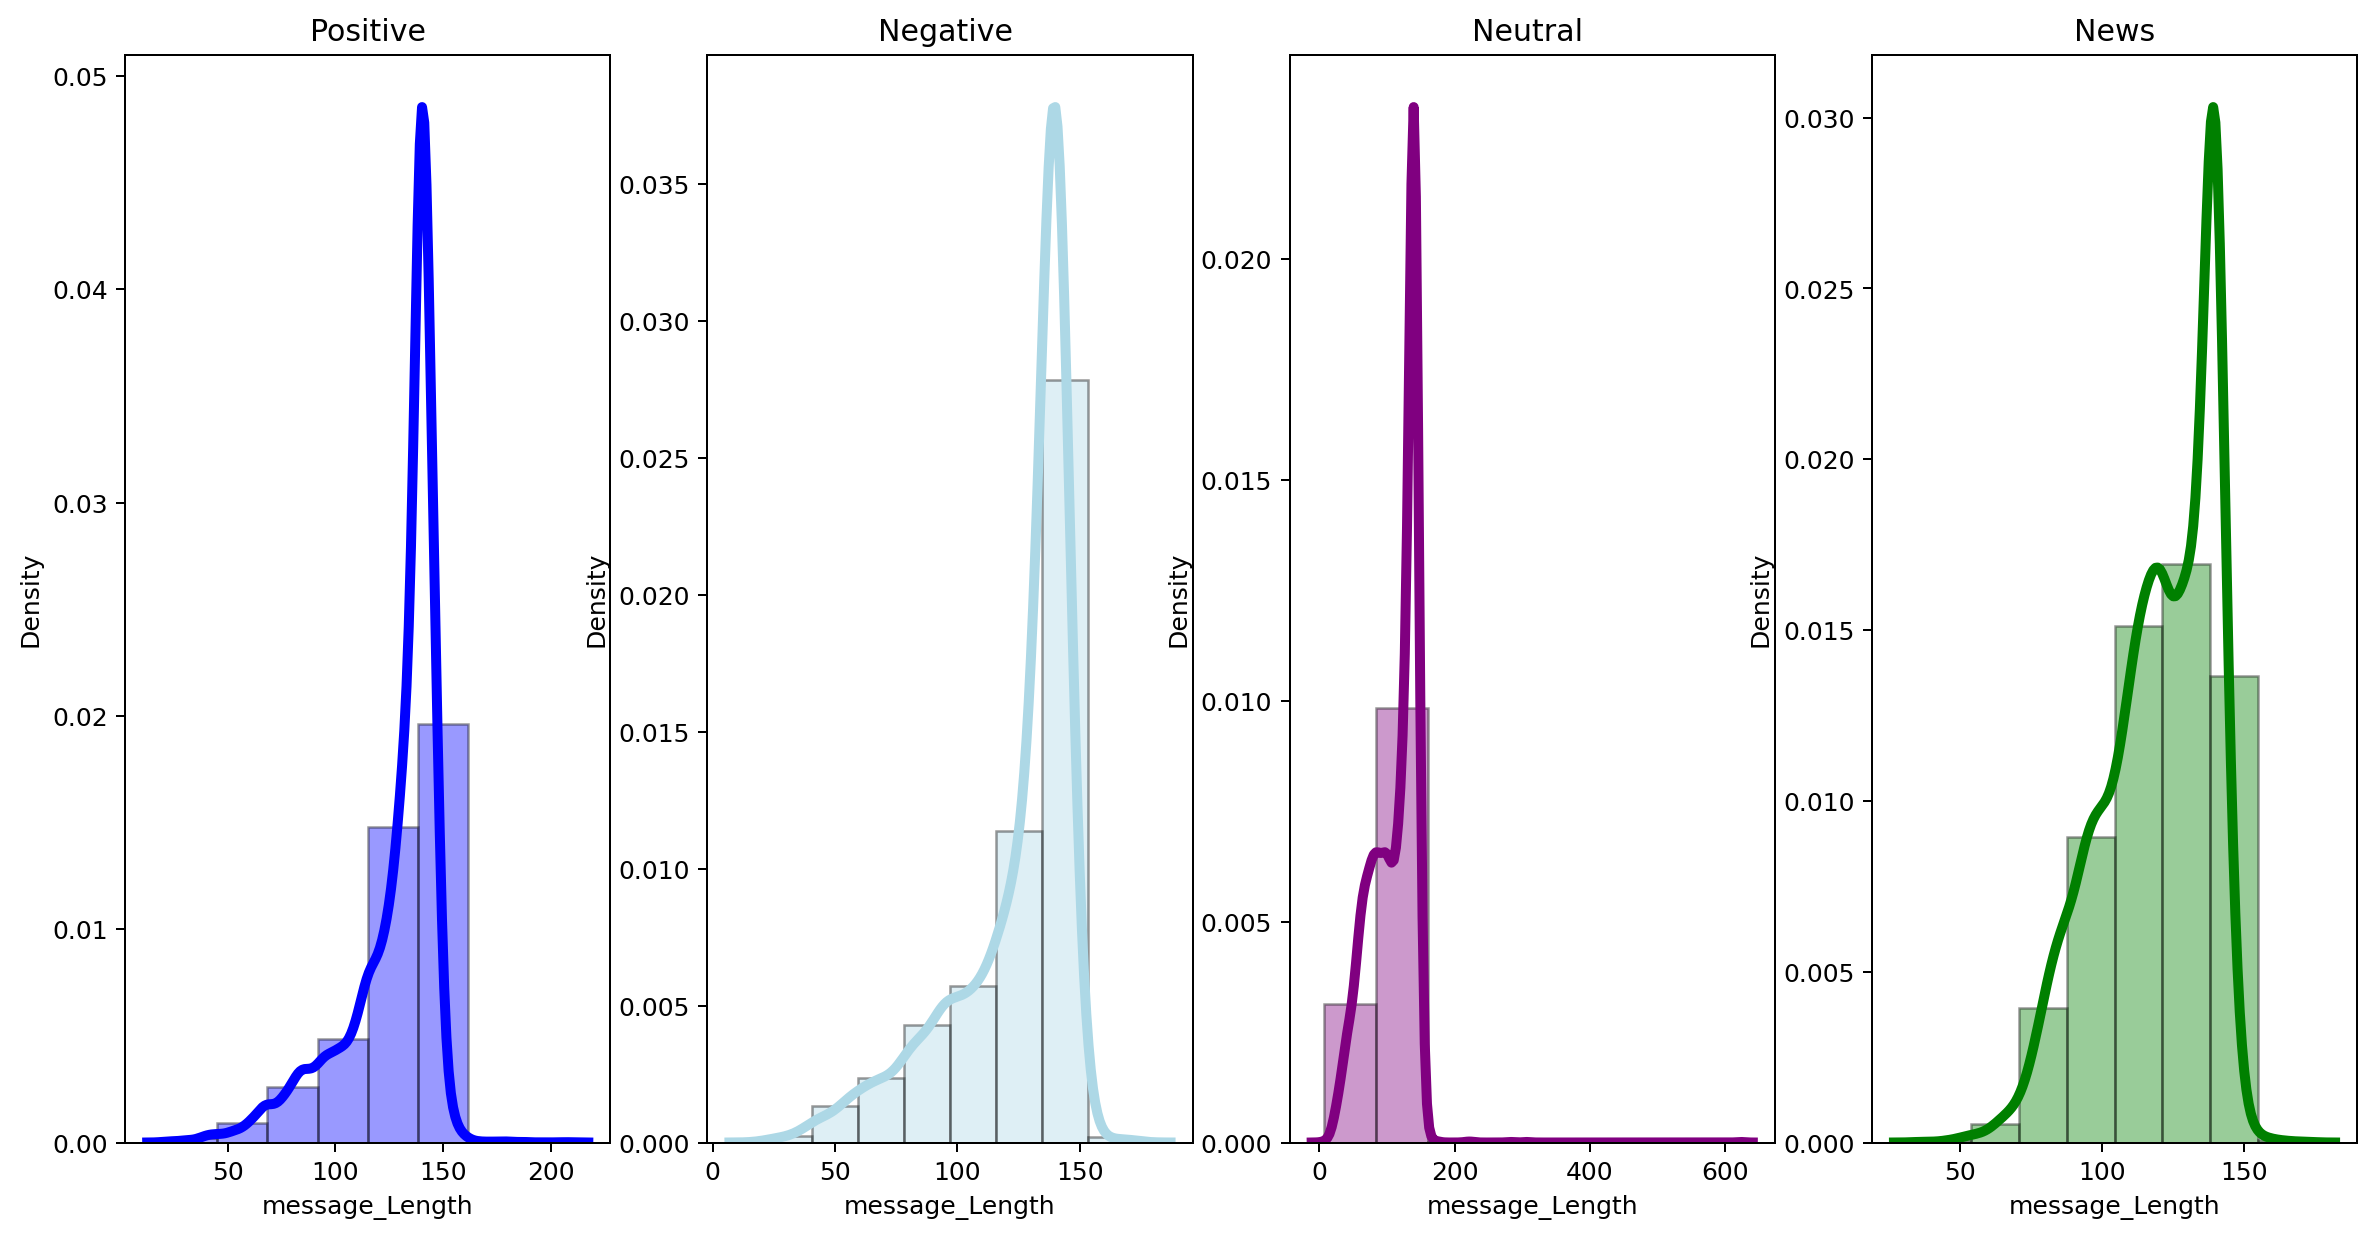

In [16]:
# Distribution plots for the label
fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(16,8))

#For Positive 
sns.distplot(traindata[traindata['sentiment']==1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'blue', 
             ax = ax1,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax1.set_title('Positive')
ax1.set_xlabel('message_Length')
ax1.set_ylabel('Density')

#For Negative 
sns.distplot(traindata[traindata['sentiment']==-1]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'lightblue', 
             ax = ax2,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax2.set_title('Negative ')
ax2.set_xlabel('message_Length')
ax2.set_ylabel('Density')

#For Neutral 
sns.distplot(traindata[traindata['sentiment']==0]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'purple',  
             ax = ax3,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax3.set_title('Neutral ')
ax3.set_xlabel('message_Length')
ax3.set_ylabel('Density')

#For Neews
sns.distplot(traindata[traindata['sentiment']==2]['message'].str.len(), hist=True, kde=True,
             bins=int(200/25), color = 'green', 
             ax = ax4,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax4.set_title('News')
ax4.set_xlabel('message_Length')
ax4.set_ylabel('Density')

It can be seen that the average length of messages for all sentiments is not suprising as a tweet is only limited to 140 characters. However, the density contrast between positive and negative sentiments is interesting and will make for more unpacking later in the EDA. Now that we have explored our dataset, we can begin perfoming some analyses on it.

##  Exploratory Data Analysis

The EDA performs investigative and detective analysis of our data to see if we can unearth any insights. we work on the text data. The data is being generated from tweets, digital media platforms, blogs, and a whole host of other sources. As a data scientists and an NLP enthusiasts, it’s important to analyze all this text data to help organizations make data-driven decisions.

In [17]:
working_df = traindata.copy()
# Labeling the target
working_df['sentiment'] = [['Negative', 'Neutral', 'Positive', 'News'][x+1] for x in working_df['sentiment']]

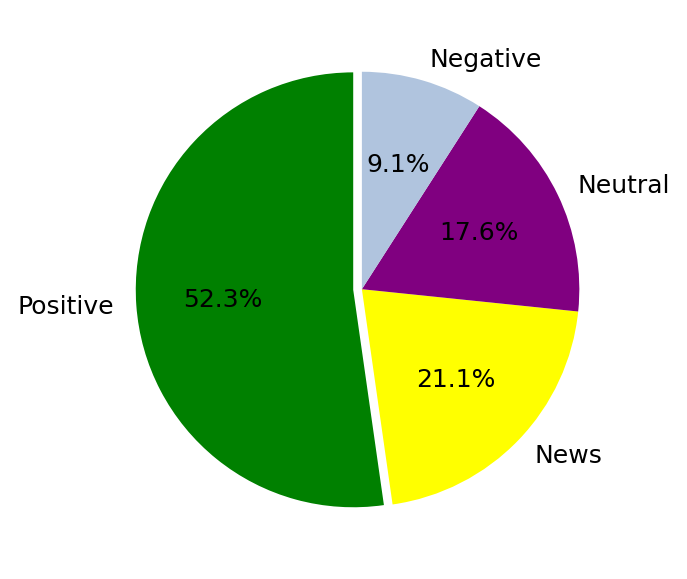

In [18]:
# checking the numerical distribution
values = working_df['sentiment'].value_counts()/working_df.shape[0]
labels = (working_df['sentiment'].value_counts()/working_df.shape[0]).index
colors = ['green', 'yellow', 'purple', 'lightsteelblue']
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0, 0, 0), colors=colors)
plt.show()

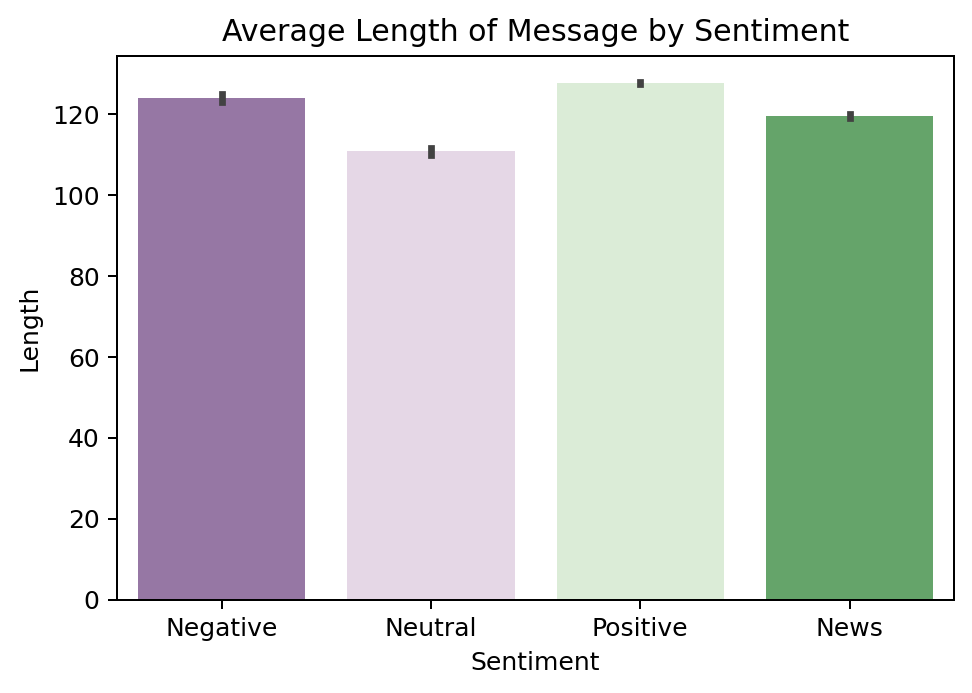

In [19]:
# Visualizing text lengths for each sentiment
sns.barplot(x='sentiment', y=working_df['message'].apply(len) ,data = working_df, palette='PRGn')
plt.ylabel('Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Message by Sentiment')
plt.show()

It can be noted that earlier there was an imbalance of classes in the daset, this can lead to a disproportionate ratio of observations in each class, causing problems as most algorithms are designed to maximize accuracy and reduce error. We therefore continue to analyse and evaluate for more insights to be derived from the dataset as we prepared to balance later on in the analysis.

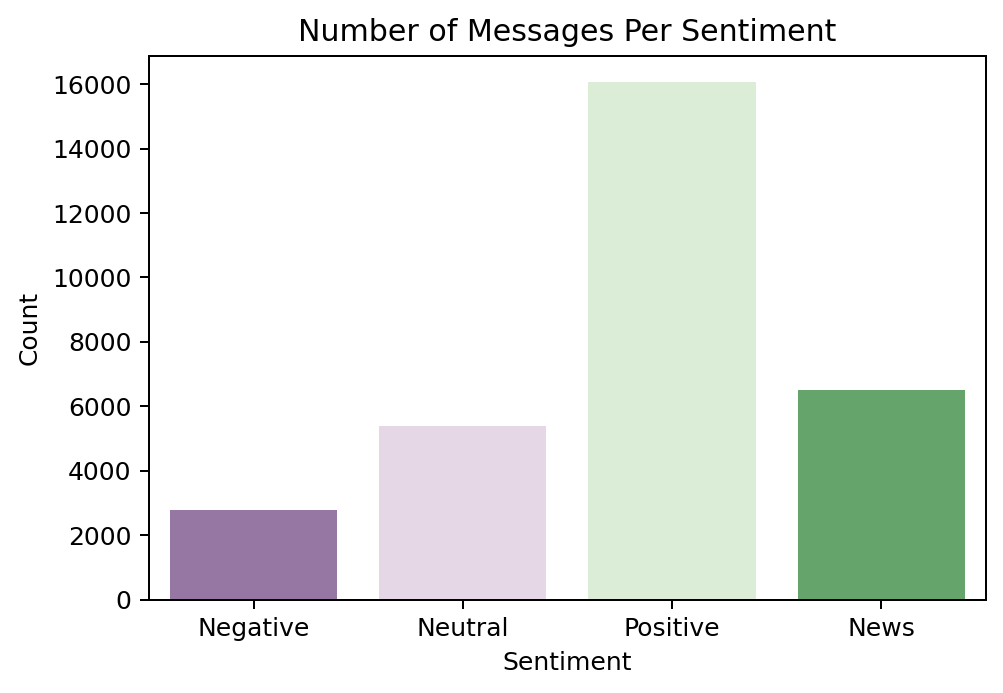

In [20]:
sns.countplot(x='sentiment' ,data = working_df, palette='PRGn')
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.title('Number of Messages Per Sentiment')
plt.show()

In [21]:
# Extracting Users in a column
working_df['users'] = [''.join(re.findall(r'@\w{,}', line)) 
                       if '@' in line else np.nan for line in working_df.message]

# Creating a column of hastags
working_df['hashtags'] = [' '.join(re.findall(r'#\w{,}', line)) 
                       if '#' in line else np.nan for line in working_df.message]

In [22]:
# Generating Counts of users
counts = working_df[['message', 'users']].groupby('users', as_index=False).count().sort_values(by='message', ascending=False)

In [23]:
# Top 5 most popular
counts.head()

,users,message
6286,@StephenSchlegel,362
6010,@SenSanders,312
11491,@realDonaldTrump,217
12324,@thehill,161
804,@BernieSanders,152


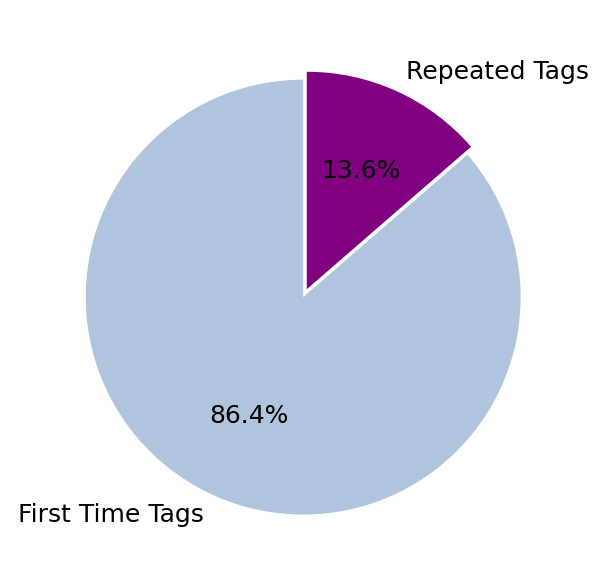

In [24]:
# checking the numerical distribution
values = [sum(np.array(counts['message']) == 1)/len(counts['message']), sum(np.array(counts['message']) != 1)/len(counts['message'])]
labels = ['First Time Tags', 'Repeated Tags']
colors = ['lightsteelblue', "purple"]
plt.pie(x=values, labels=labels, autopct='%1.1f%%', startangle=90, explode= (0.04, 0), colors=colors)
plt.show()

In [25]:
repeated_tags_rate = round(sum(np.array(counts['message']) > 1)*100/len(counts['message']), 1)
print(f"{repeated_tags_rate} percent of the data are from repeated tags")

13.6 percent of the data are from repeated tags


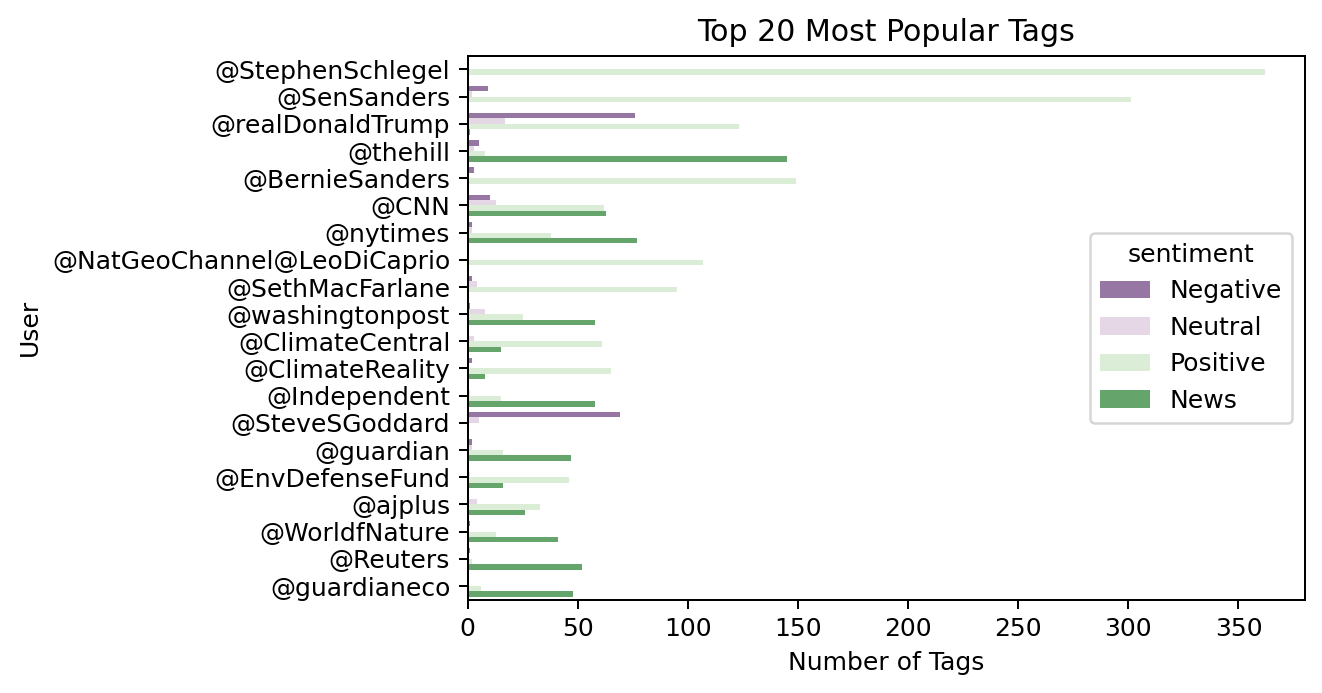

In [26]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(y="users", hue="sentiment", data=working_df, palette='PRGn',
              order=working_df.users.value_counts().iloc[:20].index) 

plt.ylabel('User')
plt.xlabel('Number of Tags')
plt.title('Top 20 Most Popular Tags')
plt.show()
#plt.xticks(rotation=90)

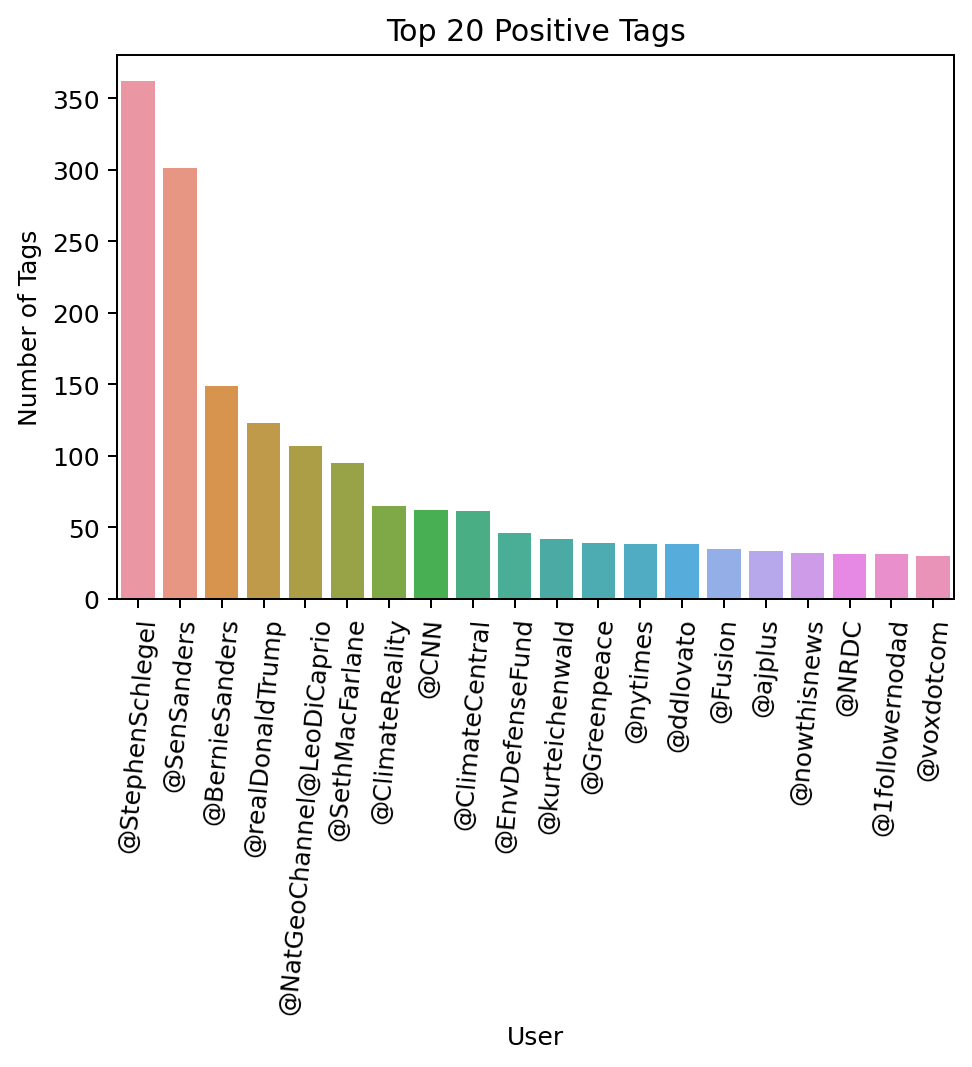

In [27]:
#Now that we've had a look at the tweets themselves as well as the users, we now analyse the hastags:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Positive'],
              order=working_df[working_df['sentiment'] == 'Positive'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Positive Tags')
plt.xticks(rotation=85)
plt.show()

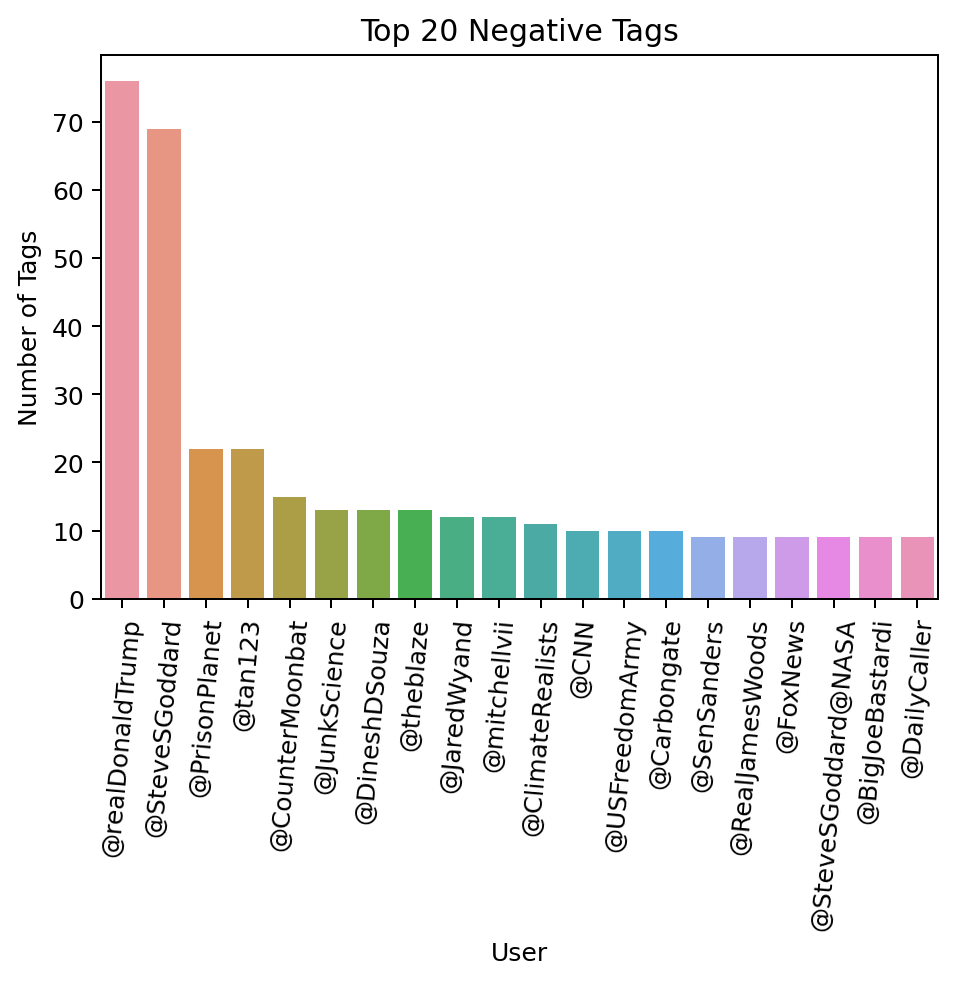

In [28]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Negative'],
              order=working_df[working_df['sentiment'] == 'Negative'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Negative Tags')
plt.xticks(rotation=85)
plt.show()

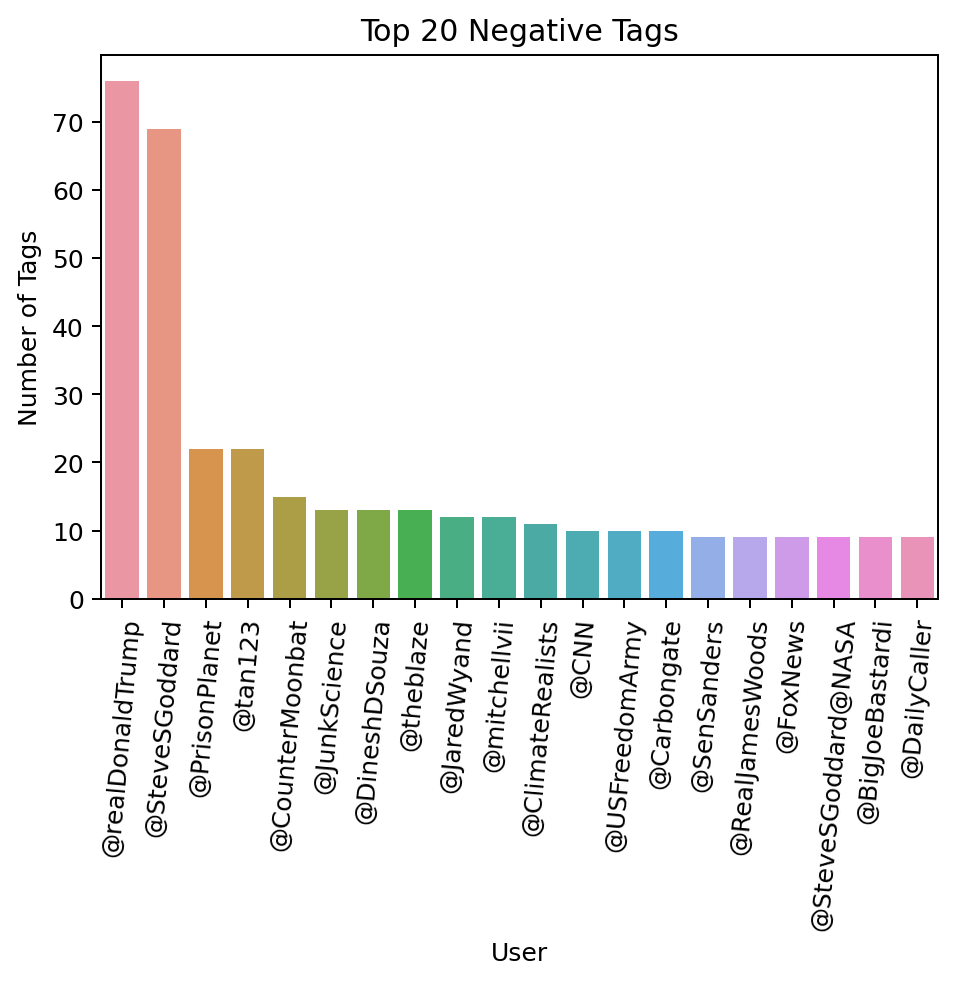

In [29]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'Negative'],
              order=working_df[working_df['sentiment'] == 'Negative'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 Negative Tags')
plt.xticks(rotation=85)
plt.show()

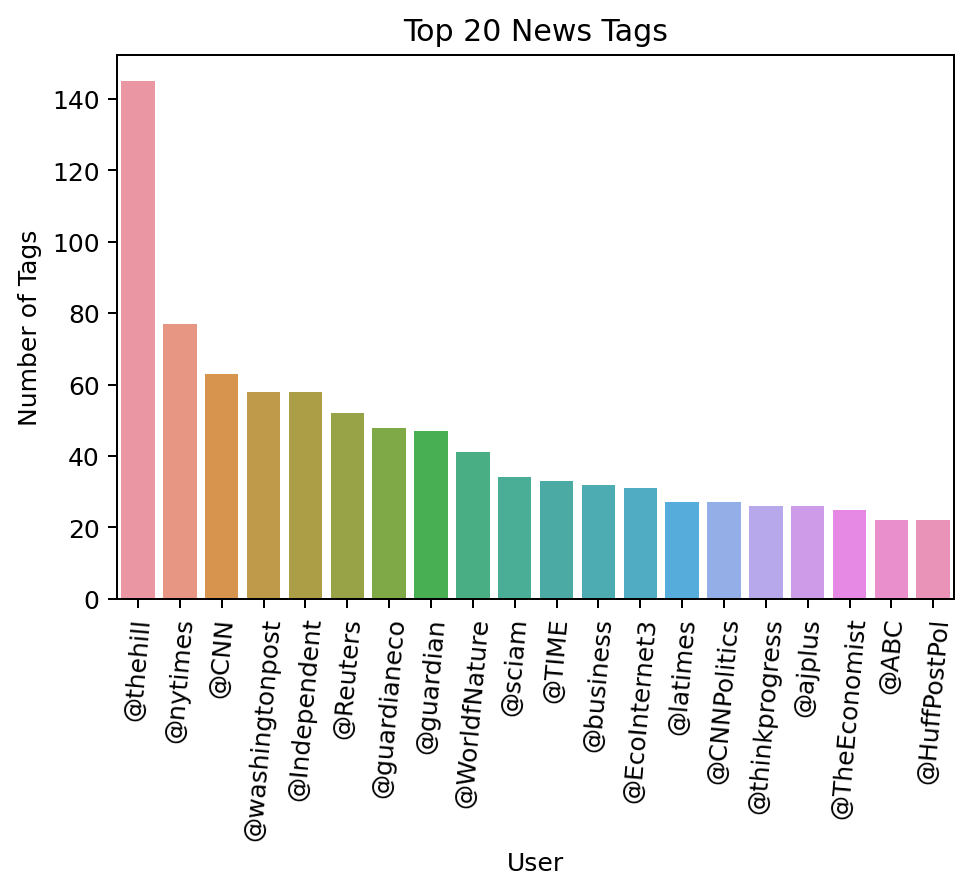

In [30]:
# Analysis of most popular tags, sorted by populariy
sns.countplot(x="users", data=working_df[working_df['sentiment'] == 'News'],
              order=working_df[working_df['sentiment'] == 'News'].users.value_counts().iloc[:20].index) 

plt.xlabel('User')
plt.ylabel('Number of Tags')
plt.title('Top 20 News Tags')
plt.xticks(rotation=85)
plt.show()

## Data Cleaning

This stage of Data Cleaning is the process of detecting and correcting corrupt or inaccurate records from the dataset and identifying incomplete, incorrect, inaccurate or irrelevant parts of the data. This stage applies database normalization which is the process of structuring a relational database in accordance with a series of normal forms in order to reduce data redundancy. Applying it will aslo help improve data integrity as it entails organizing the attributes of a dataset to ensure that their dependencies are properly enforced by database integrity constraints. Stemming and Lemmatization are techniques in the field of Natural Language Processing that are used to prepare text, words, and documents for further processing.

A stemmer will return the stem of a word, which needn't be identical to the morphological root of the word. It usually sufficient that related words map to the same stem,even if the stem is not in itself a valid root, while in lemmatisation, it will return the dictionary form of a word, which must be a valid word.

In [31]:
# Testing the PorterStemmer 
stemmer = PorterStemmer()
print("The stemmed form of typing is: {}".format(stemmer.stem("typing")))
print("The stemmed form of types is: {}".format(stemmer.stem("types")))
print("The stemmed form of type is: {}".format(stemmer.stem("type")))

The stemmed form of typing is: type
The stemmed form of types is: type
The stemmed form of type is: type


lemmatisation means that the part of speech of a word should be first determined and the normalisation rules will be different for different part of speech, while the stemmer operates on a single word without knowledge of the context, and therefore cannot discriminate between words which have different meanings depending on part of speech.

In [32]:
# Testing Lemmatization
lemm = WordNetLemmatizer()
print("In  case of Lemmatization, typing is: {}".format(lemm.lemmatize("typing")))
print("In  case of Lemmatization, types is: {}".format(lemm.lemmatize("types")))
print("In  case of Lemmatization, type is: {}".format(lemm.lemmatize("type")))

In  case of Lemmatization, typing is: typing
In  case of Lemmatization, types is: type
In  case of Lemmatization, type is: type


This also need to also transform some of the messages into a more digestible form and keeping words and items that ar otherwise discarded. We will carry out this process using the nlp tool below.

In [33]:
pip install nlppreprocess

Note: you may need to restart the kernel to use updated packages.


In [34]:
from nlppreprocess import NLP
nlp = NLP()
nlp.process('shouldnt')

'should not'

In [35]:
nlp.process('There is no good here')

'There no good'

The following function is an important step in the data mining process. In this case of classification, preprocessing data means; Data cleaning, Fill in missing values, smoothing noisy data and resolving any existing inconsistencies. Success in the steps will then make it possible and some-what easy for us to perform Data integration, Data transformation, Normalization and aggregation as well as Data reduction.

In [36]:
# Data cleaning for furthur sentiment analysis


def cleaner(line):
    '''
    For preprocessing the data, we regularize, transform each upper case into lower case, tokenize,
    normalize and remove stopwords. Normalization transforms a token to its root word i.e. 
    These words would be transformed from "love loving loved" to "love love love."
    
    '''

    # Removes RT, url and trailing white spaces
    line = re.sub(r'^RT ','', re.sub(r'https://t.co/\w+', '', line).strip()) 

    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # removes emoticons,
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    line = emojis.sub(r'', line)

    
    # Removes puctuation
    punctuation = re.compile("[.;:!\'’‘“”?,\"()\[\]]")
    tweet = punctuation.sub("", line.lower()) 

    # Removes stopwords
    nlp_for_stopwords = NLP(replace_words=True, remove_stopwords=True, 
                            remove_numbers=True, remove_punctuations=False) 
    tweet = nlp_for_stopwords.process(tweet) # This will remove stops words that are not necessary. The idea is to keep words like [is, not, was]
    # https://towardsdatascience.com/why-you-should-avoid-removing-stopwords-aa7a353d2a52
    # print("After removing stopwords:\n", tweet, '\n'*2)

    # tokenisation
    # We used the split method instead of the word_tokenise library because our tweet is already clean at this point
    # and the twitter data is not complicated
    tweet = tweet.split() 

    # POS 
    # Part of Speech tagging is essential to ensure Lemmatization perfoms well.
    pos = pos_tag(tweet)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tweet = ' '.join([lemmatizer.lemmatize(word, po[0].lower()) 
                      if (po[0].lower() in ['n', 'r', 'v', 'a'] and word[0] != '@') else word for word, po in pos])

    return tweet

In [37]:
text1 = cleaner(tweet)
print('BEFORE')
print(tweet, '\n'*2)
print('AFTER')
print(text1)

BEFORE
RT @T_S_P_O_O_K_Y: @beardoweird0 @20committee I actually have a degree in Environmental Studies - and yes - man made climate change is a ho… 


AFTER
@t_s_p_o_o_k_y @beardoweird @committee actually degree in environmental study - and yes - man make climate change ho…


In [38]:
cleaned = traindata['message'].apply(cleaner)

In [39]:
working_df['clean'] = cleaned

In [40]:
cleaned.head()

0    @darreljorstad funny hell canada demand gender...
1    biggest lie about climate change and global wa...
2    come revelation $q$global warming$q$ #fraud re...
3    @dineshdsouza let see world end when @realdona...
4    @stevesgoddard obama no control over climate w...
Name: message, dtype: object

In [41]:
# Combining all the messages
text_before_cleaning = " ".join(tweet for tweet in traindata['message'])
text_after_cleaning = " ".join(tweet for tweet in cleaned)
# print ("There are {} characters in the combination of all tweets.".format(len(text)))

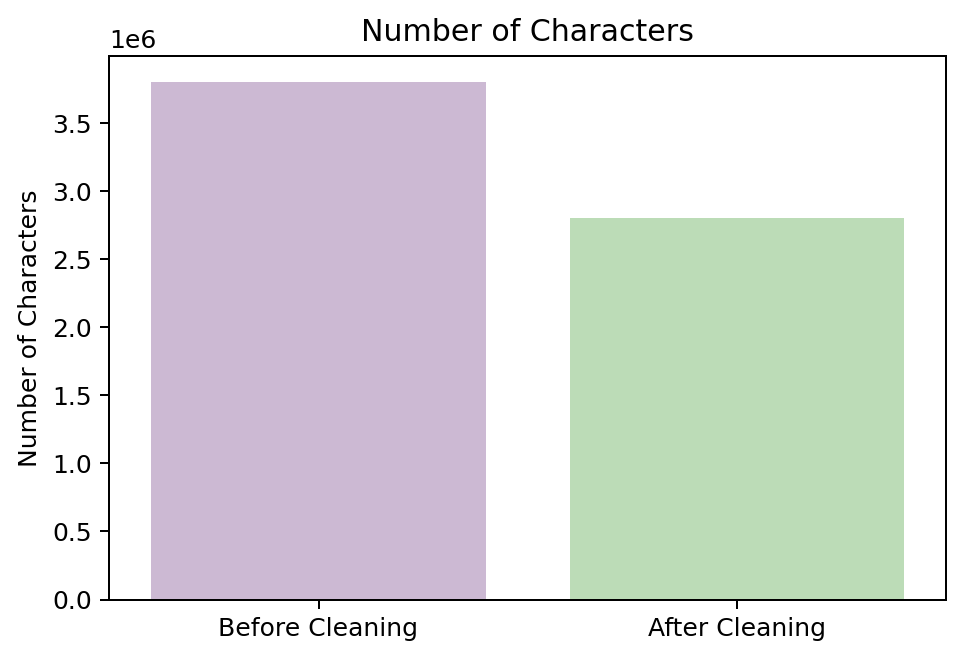

In [42]:
# Numbers of characters
sns.barplot(x=['Before Cleaning', 'After Cleaning'], y=[len(text_before_cleaning), len(text_after_cleaning)], palette='PRGn')
# sns.countplot(x=[] ,data = working_df, palette='PRGn')
plt.ylabel('Number of Characters')
# plt.xlabel('Sentiment')
plt.title('Number of Characters')
plt.show()

## Feature Engineering and Selection

Feature Extraction
For our Feature Extraction, we use CV and TF-IDF. These are tools which will help encode the words as integers or floating point values for use as input to a machine learning algorithm.

CountVectorizer counts the word frequencies, while the TFIDFVectorizer (The term frequency-inverse document frequency) is a weight whose value increases proportionally to count, but is inversely proportional to frequency of the word in the corpus. The TF-IDF weight is a weight often used in information retrieval and text mining. Tf-idf can be successfully used for stop-words filtering in various subject fields including text summarization and classification.

In [43]:
# Converting the collection of clean messages to a matrix of token counts
corpus = working_df['clean']

vectorizer = CountVectorizer()
count_vectorized = vectorizer.fit_transform(corpus)
#print(vectorizer.get_feature_names())
#print(X.toarray())

In [44]:
# Converting the collection of clean messages to a matrix of TF-IDF features
data = working_df['clean']

vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
vectorized = vectorizer.fit_transform(data)
#print(vectorizer.get_feature_names())
#print(X.toarray())

In some problems the countsvec is better suited for model training in others the tfidf representation is the best choice. We have decided to try them both. Although the two representations are very similar and therefore carry approximately the same information, it could be the case that you will get better precision by using the full set of features(tfidf+counts).

In [45]:
# Using sparse to train the model using both representations.
import scipy.sparse

# Defining the features as well as the label
X = scipy.sparse.hstack([vectorized, count_vectorized])
y = working_df['sentiment']

## Model Building

In [46]:
#importing some of the models that will be trained
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [47]:
from sklearn.model_selection import train_test_split

# Splitting the previously defined features and label of your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [48]:
# Creating a list of all the models to train
algs = [LogisticRegression(random_state = 5), SVC(kernel = 'linear', random_state = 5), SVC(kernel = 'rbf', random_state = 5)
        ,MultinomialNB(), KNeighborsClassifier(), DecisionTreeClassifier(max_depth=6),RandomForestClassifier()]

In [49]:
# Fitting models onto the training data and predicting.
for i in range(0, len(algs)):
    text_clf = Pipeline([('clf', algs[i])])
    ##lowercase = True,stop_words='english', ngram_range=(1, 2), analyzer='word',max_df = 0.8
    text_clf.fit(X_train, y_train)  
    predictions = text_clf.predict(X_test)
    
    
    print(algs[i])
    print(metrics.confusion_matrix(y_test,predictions))
    print(metrics.classification_report(y_test,predictions))
    print('F1_score: ',round(metrics.f1_score(y_test,predictions, average = 'weighted'),3))
    print('-------------------------------------------------------')

LogisticRegression(random_state=5)
[[ 426  175   53  252]
 [  90  819  142  725]
 [  18   68 1512  505]
 [  82  385  423 4476]]
              precision    recall  f1-score   support

    Negative       0.69      0.47      0.56       906
     Neutral       0.57      0.46      0.51      1776
        News       0.71      0.72      0.71      2103
    Positive       0.75      0.83      0.79      5366

    accuracy                           0.71     10151
   macro avg       0.68      0.62      0.64     10151
weighted avg       0.70      0.71      0.70     10151

F1_score:  0.705
-------------------------------------------------------
SVC(kernel='linear', random_state=5)
[[ 485  169   49  203]
 [ 156  850  135  635]
 [  26  126 1497  454]
 [ 163  541  476 4186]]
              precision    recall  f1-score   support

    Negative       0.58      0.54      0.56       906
     Neutral       0.50      0.48      0.49      1776
        News       0.69      0.71      0.70      2103
    Positive     

## Model Selection

## Model Deployment